# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up graphlab create

In [2]:
import graphlab

A newer version of GraphLab Create (v1.10.1) is available! Your current version is v1.9.

You can use pip to upgrade the graphlab-create package. For more information see https://dato.com/products/create/upgrade.


# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [5]:
sales = graphlab.SFrame('kc_house_data.gl/')

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [6]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [7]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [8]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000002  | 1.146801     | 6962915.603493     | 426631.749026 |

| 2         | 3        | 0.000002  | 1.176580     | 6843144.200219     | 392488.929838 |

| 3         | 4        | 0.000002  | 1.193685     | 6831900.032123     | 385340.166783 |

| 4         | 5        | 0.000002  | 1.212154     | 6847166.848958     | 384842.383767 |

| 5         | 6        | 0.000002  | 1.223060     | 6869667.895833     | 385998.458623 |

| 6         | 7        | 0.000002  | 1.233054     | 6847177.773672     | 380824.455891 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Find what features had non-zero weight.

In [9]:
model_all.coefficients[model_all.coefficients['value']>0]['name'][0:]

dtype: str
Rows: 6
['(intercept)', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'grade', 'sqft_above']

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [10]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [11]:
import numpy as np

In [12]:
errors = {}
for l1 in np.logspace(1, 7, num=13):
    model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=l1, verbose = False)
    pred = model.predict(validation)
    res = validation['price'] - pred
    rss = sum(res**2)
    errors[l1] = rss
    print l1, " : ", rss

10.0  :  6.25766285142e+14
31.6227766017  :  6.25766285362e+14
100.0  :  6.25766286058e+14
316.227766017  :  6.25766288257e+14
1000.0  :  6.25766295212e+14
3162.27766017  :  6.25766317206e+14
10000.0  :  6.25766386761e+14
31622.7766017  :  6.25766606749e+14
100000.0  :  6.25767302792e+14
316227.766017  :  6.25769507644e+14
1000000.0  :  6.25776517727e+14
3162277.66017  :  6.25799062845e+14
10000000.0  :  6.25883719085e+14


In [13]:
print min(errors, key=errors.get)

10.0


*** QUIZ QUESTIONS ***
1. What was the best value for the `l1_penalty`?
2. What is the RSS on TEST data of the model with the best `l1_penalty`?

In [14]:
model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=10.0, verbose = False)
pred = model.predict(testing)
res = testing['price'] - pred
rss = sum(res**2)
print rss

1.56983602382e+14


***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [15]:
print (model.coefficients['value']).nnz()
print model.coefficients[model.coefficients['value']>0]['name'][0:]

18
['(intercept)', 'bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']


# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [16]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [17]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [18]:
nnzs = {}
for l1_penalty in np.logspace(8, 10, num=20):
    model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=l1_penalty, verbose = False)
    nnzs[l1_penalty] = model.coefficients['value'].nnz()
print nnzs

{100000000.0: 18, 206913808.11147901: 18, 1128837891.6846883: 15, 6158482110.6602545: 3, 1832980710.8324375: 13, 3792690190.7322536: 6, 2976351441.6313133: 10, 127427498.57031322: 18, 545559478.11685145: 17, 1438449888.2876658: 15, 263665089.87303555: 17, 162377673.91887242: 18, 885866790.41008317: 16, 10000000000.0: 1, 335981828.62837881: 17, 7847599703.5146227: 1, 695192796.17755914: 17, 4832930238.5717525: 5, 2335721469.0901213: 12, 428133239.8719396: 17}


Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzero` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzero` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [19]:
l1_penalty_min = 0
for k in nnzs.keys():
    if nnzs[k] > max_nonzeros and k > l1_penalty_min:
        l1_penalty_min = k
print l1_penalty_min, " : ", nnzs[l1_penalty_min]

2976351441.63  :  10


In [20]:
l1_penalty_max = l1_penalty_values[-1]
for k in nnzs.keys():
    if nnzs[k] < max_nonzeros and k < l1_penalty_max:
        l1_penalty_max = k
print l1_penalty_max, " : ", nnzs[l1_penalty_max]

3792690190.73  :  6


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

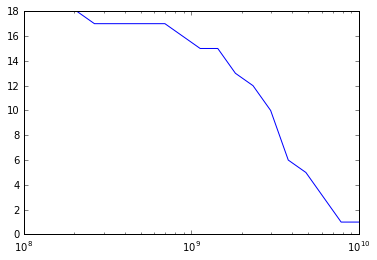

In [22]:
plt.xscale('log')
plt.plot(l1_penalty_values, [nnzs[k] for k in sorted(nnzs)])

***QUIZ QUESTIONS***

What values did you find for `l1_penalty_min` and`l1_penalty_max`? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [23]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzero`.

In [24]:
count = 0
for l1 in l1_penalty_values:
    model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=l1, verbose = False)
    nnz = model.coefficients['value'].nnz()
    if nnz == 7:
        pred = model.predict(validation)
        res = validation['price'] - pred
        rss = sum(res**2)
        print l1, "(", count, ")", " : ", rss
    count = count + 1

3448968612.16 ( 11 )  :  1.04693748875e+15
3491933809.48 ( 12 )  :  1.05114762561e+15
3534899006.81 ( 13 )  :  1.05599273534e+15
3577864204.13 ( 14 )  :  1.06079953176e+15


***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`? 3448968612.16
2. What features in this model have non-zero coefficients?

In [25]:
modelf = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=3448968612.16, verbose = False)
modelf.coefficients[modelf.coefficients['value']>0]['name'][0:]

dtype: str
Rows: 7
['(intercept)', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'grade', 'sqft_above']